In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as smd
import seaborn as sns
import pylab as py

In [16]:
data = pd.read_csv("./data/final_data/data.csv")

In [17]:
all_data_to_plot = data.drop(columns=["ID", "season", "salary_cap_perc"])

C:\Users\azernaczuk\AppData\Local\Temp\ipykernel_25068\2620940592.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


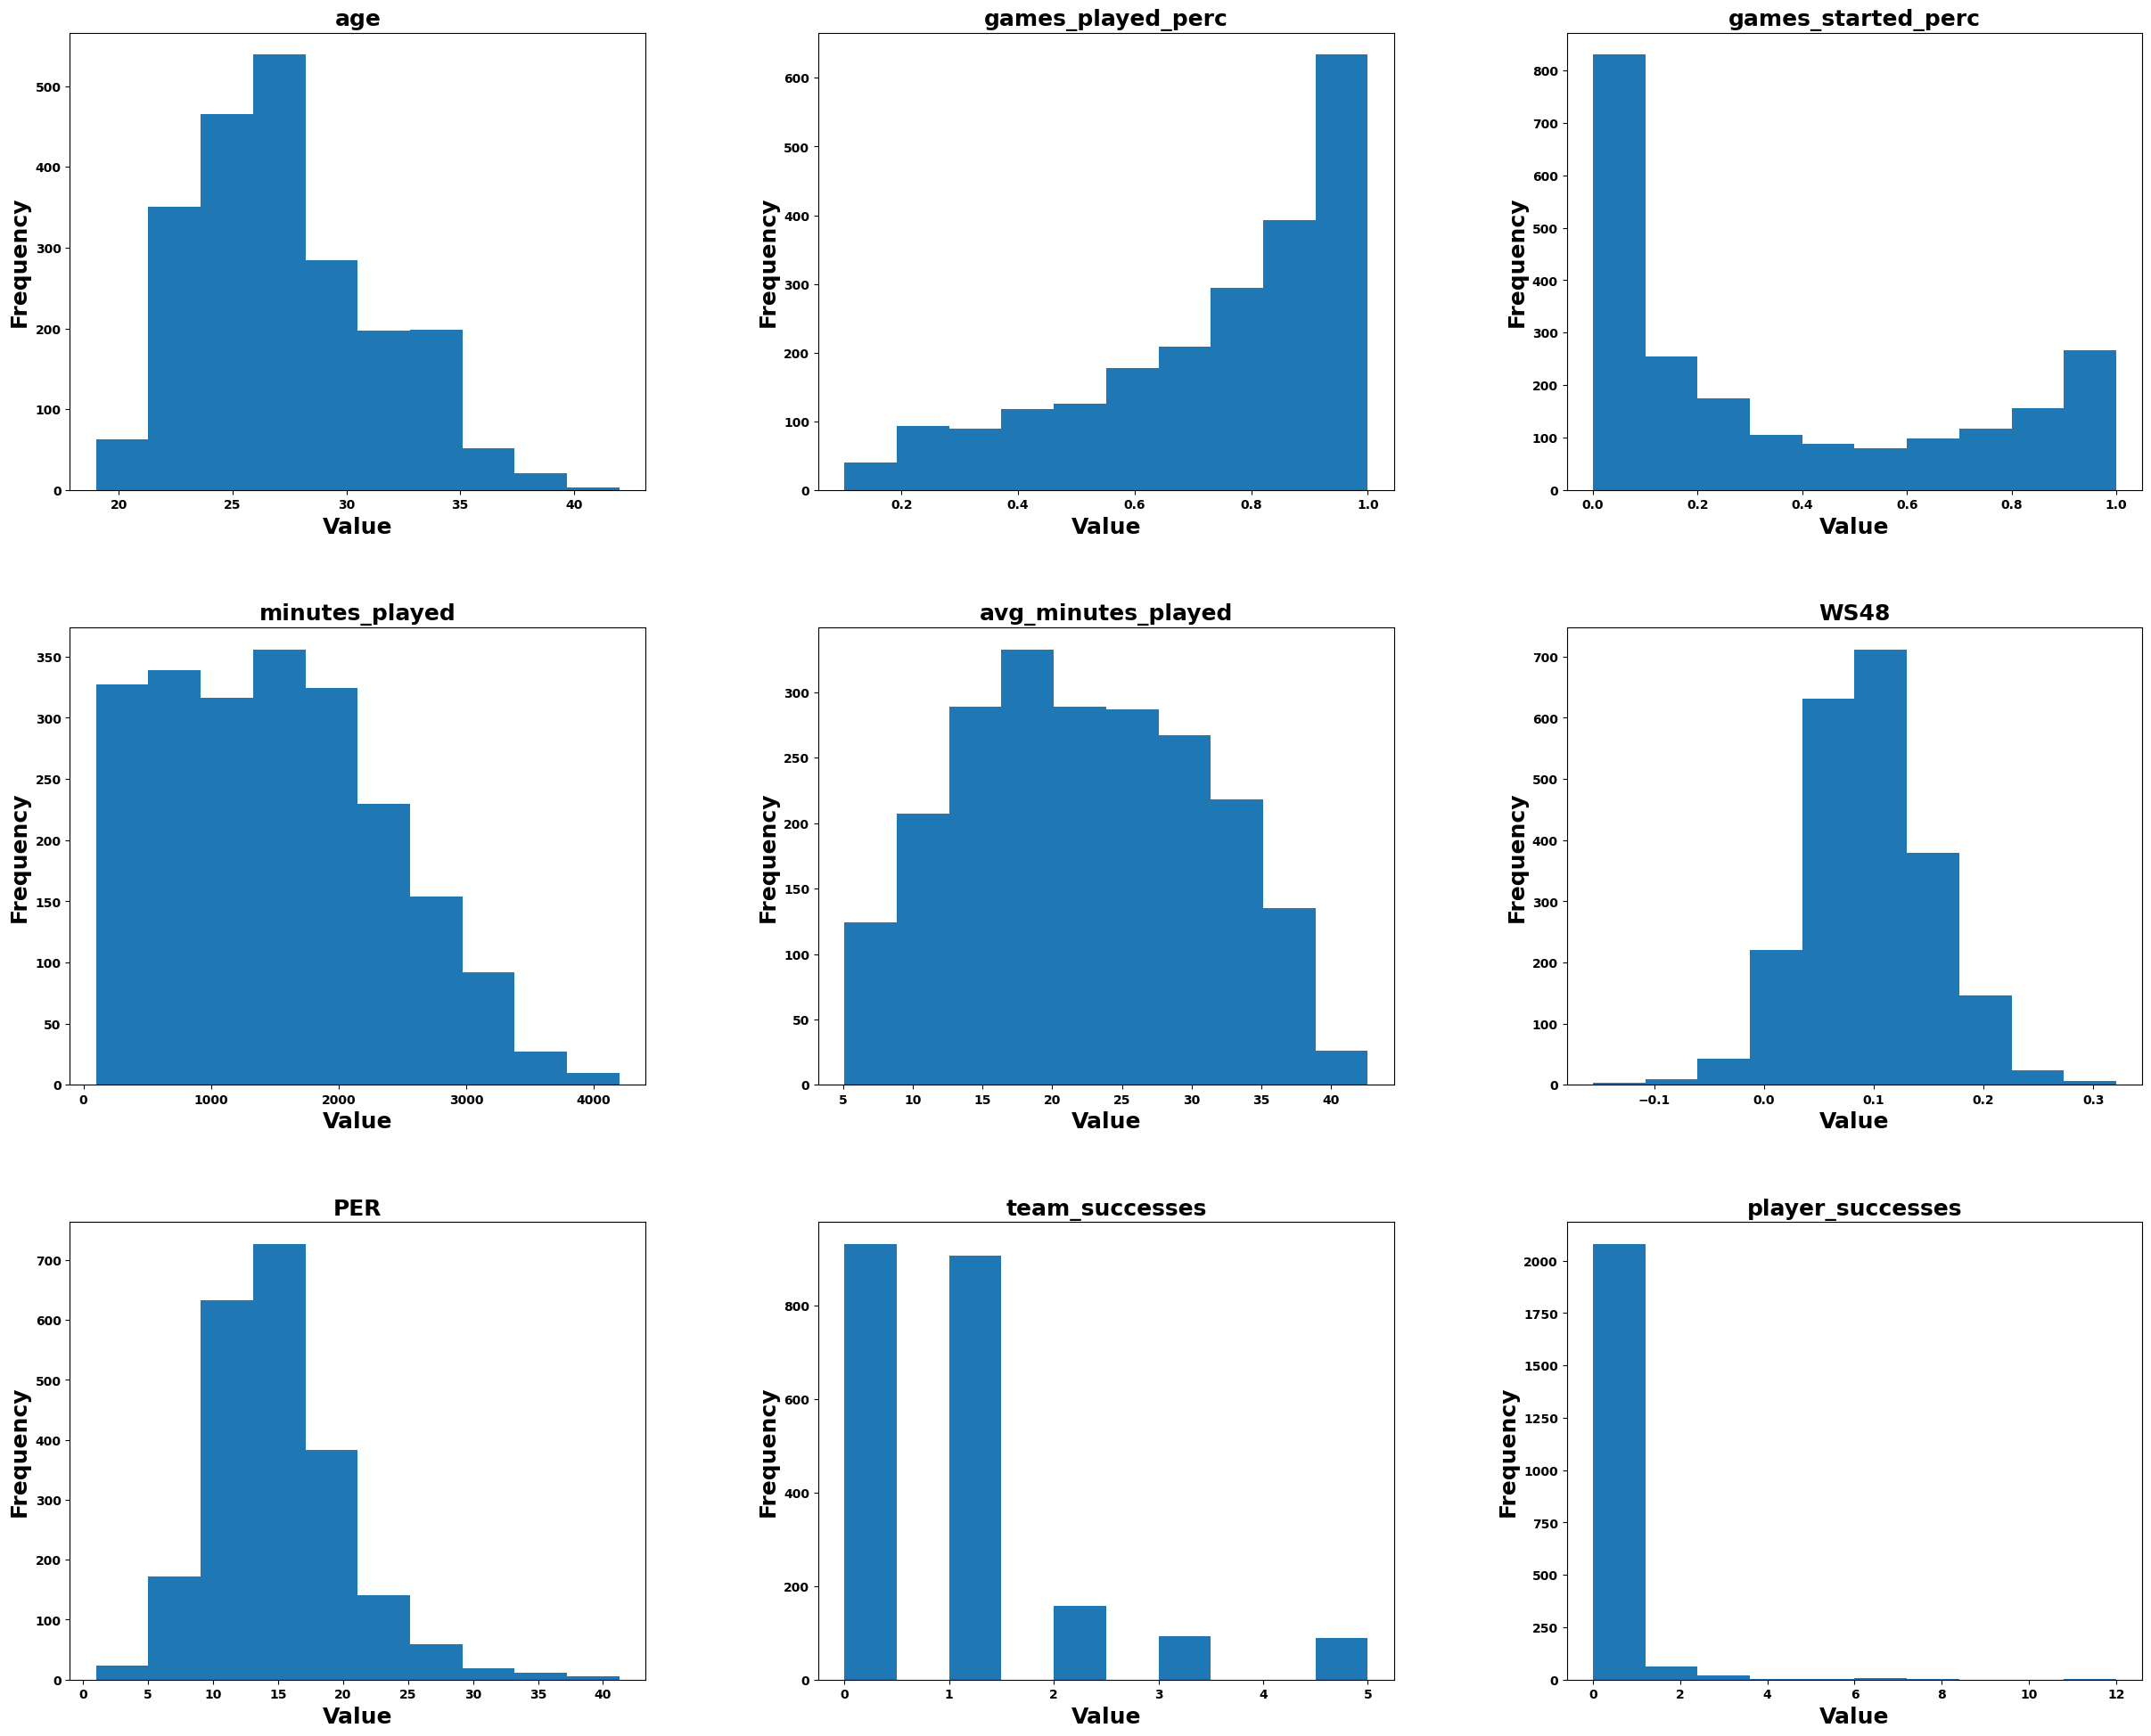

In [18]:
fig = plt.figure(figsize=(30, 24))
plt.rcParams['font.weight'] = 'bold'
gs = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)
for i, colum in enumerate(all_data_to_plot.columns):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col]) # Indexing starts at 1, not 0
    ax.hist(all_data_to_plot[colum])
    ax.set_title(f'{colum}', weight='bold', fontsize=18)
    ax.set_xlabel('Value', weight='bold', fontsize=18)
    ax.set_ylabel('Frequency', weight='bold', fontsize=18)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

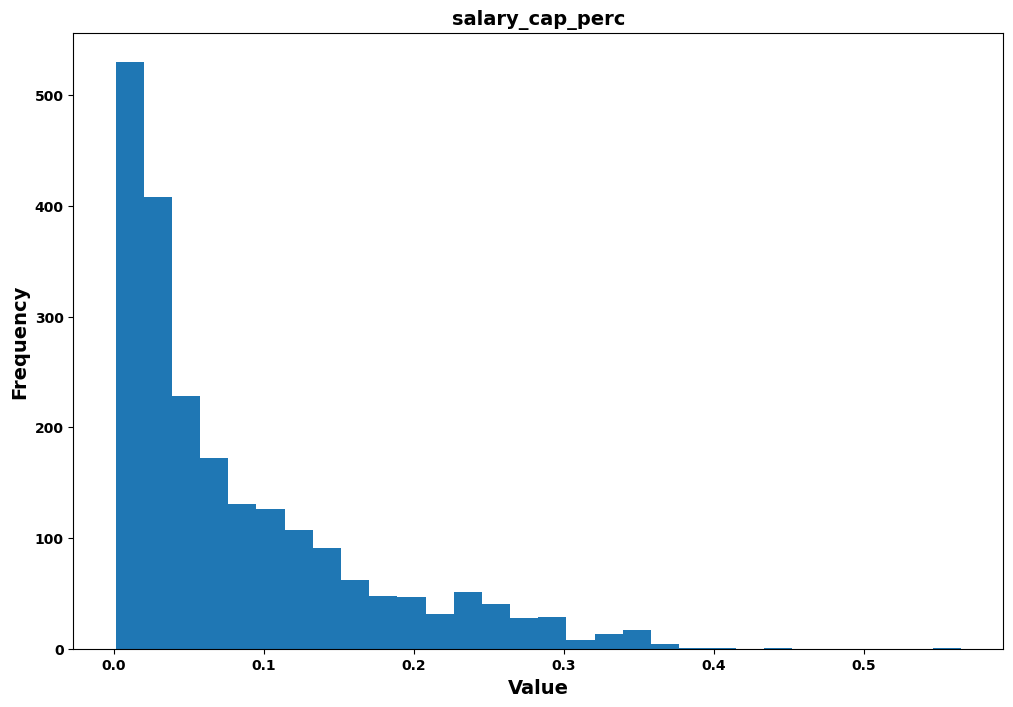

In [19]:
plt.rcParams['font.weight'] = 'bold'

# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram
ax.hist(data["salary_cap_perc"], bins=30)

# Set the title, x-axis label, and y-axis label
ax.set_title(f'salary_cap_perc', weight='bold', fontsize=14)
ax.set_xlabel('Value', weight='bold', fontsize=14)
ax.set_ylabel('Frequency', weight='bold', fontsize=14)

# Show the plot
plt.show()

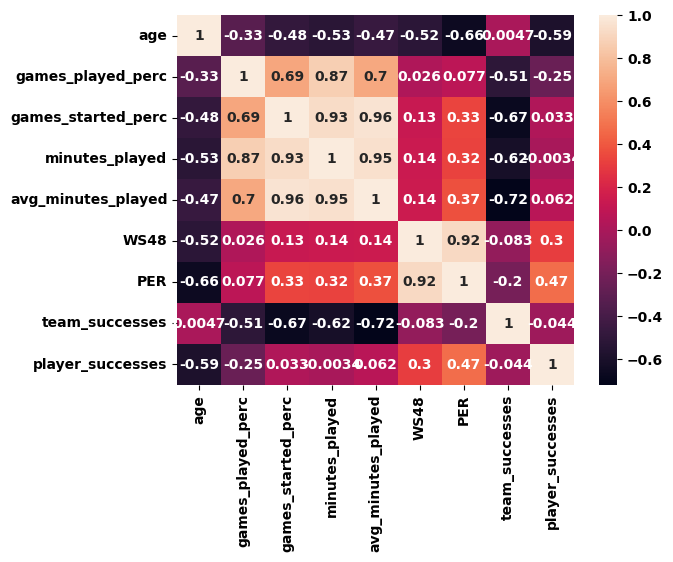

In [20]:
htmp_data = all_data_to_plot.corr()
sns.heatmap(htmp_data.corr(), annot=True)
plt.show()

In [21]:
X_train = pd.read_csv("./data/final_data/X_train.csv", encoding='utf-8')
X_test = pd.read_csv("./data/final_data/X_test.csv", encoding='utf-8')
y_train = pd.read_csv("./data/final_data/y_train.csv", encoding='utf-8')
y_test = pd.read_csv("./data/final_data/y_test.csv", encoding='utf-8')

In [22]:
X_train_log = X_train.copy()
X_train_log = X_train_log.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"])
X_train_log["age"] = X_train_log["age"].apply(lambda x: np.log2(x))
X_test_log = X_test.copy()
X_test_log = X_test_log.drop(columns=["ID", "season", "games_started_perc", "minutes_played", "PER"])
X_test_log["age"] = X_test_log["age"].apply(lambda x: np.log2(x))
y_train_log = y_train.copy()
y_train_log["salary_cap_perc"] = y_train_log["salary_cap_perc"].apply(lambda x: np.log(x))
y_test_log = y_test.copy()
y_test_log["salary_cap_perc"] = y_test_log["salary_cap_perc"].apply(lambda x: np.log(x))

In [23]:
reg = sm.OLS(y_train_log, X_train_log)
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        salary_cap_perc   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     417.2
Date:                Tue, 22 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:56:17   Log-Likelihood:                -2029.2
No. Observations:                1740   AIC:                             4072.
Df Residuals:                    1733   BIC:                             4111.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.1533      0

In [24]:
# White standard errors
robust_results = results.get_robustcov_results(cov_type='HC3')  # 'HC3' is one of the types of White standard errors
print(robust_results.summary())

                            OLS Regression Results                            
Dep. Variable:        salary_cap_perc   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     509.0
Date:                Tue, 22 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:56:20   Log-Likelihood:                -2029.2
No. Observations:                1740   AIC:                             4072.
Df Residuals:                    1733   BIC:                             4111.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.1533      0

In [25]:
results_np = sm.OLS(results.model.endog, results.model.exog).fit()

In [26]:
# RESET TEST
reset_test = smd.linear_reset(res=results_np, use_f = True)

print(f"RESET test statistic: {reset_test.statistic}")
print(f"RESET p-value: {reset_test.pvalue}")

RESET test statistic: 18.958683727003454
RESET p-value: 7.1652485237501e-09


In [27]:
# RAINBOW TEST
rainbow_statistic, rainbow_p_value = smd.linear_rainbow(results)

print(f"Rainbow statistic: {rainbow_statistic}")
print(f"Rainbow p-value: {rainbow_p_value}")

Rainbow statistic: 0.8872460160005646
Rainbow p-value: 0.9607932942782075


In [28]:
# WHITE TEST
test_statistic, p_value, f_statistic, f_p_value = smd.het_white(results.resid, results.model.exog)

print(f"White statistic: {test_statistic}")
print(f"White p-value: {p_value}")
print(f"White F-statistic: {f_statistic}")
print(f"White F-test p-value: {f_p_value}")

White statistic: 153.32541953650835
White p-value: 1.276460806049174e-19
White F-statistic: 6.127259781034066
White F-test p-value: 1.1379780552592093e-20


In [29]:
# BREUSCH-PAGAN TEST
lm_statistic, lm_p_value, f_statistic, f_p_value = smd.het_breuschpagan(results.resid, results.model.exog)

print(f"Breusch-Pagan statistic: {lm_statistic}")
print(f"Breusch-Pagan p-value: {lm_p_value}")
print(f"Breusch-Pagan F-statistic: {f_statistic}")
print(f"Breusch-Pagan F-test p-value: {f_p_value}")

Breusch-Pagan statistic: 131.37994833316452
Breusch-Pagan p-value: 6.582569342757363e-26
Breusch-Pagan F-statistic: 23.589727338602312
Breusch-Pagan F-test p-value: 6.313084432578974e-27


In [30]:
bg_test_statistic, bg_p_value, f_statistic, f_p_value = smd.acorr_breusch_godfrey(results, nlags=1)

print(f"Breusch-Godfrey statistic: {bg_test_statistic}")
print(f"Breusch-Godfrey p-value: {bg_p_value}")
print(f"Breusch-Godfrey F-statistic: {f_statistic}")
print(f"Breusch-Godfrey F-test p-value: {f_p_value}")

Breusch-Godfrey statistic: 0.47804569625366833
Breusch-Godfrey p-value: 0.48930887194527883
Breusch-Godfrey F-statistic: 0.4759785548335513
Breusch-Godfrey F-test p-value: 0.4903419624389517


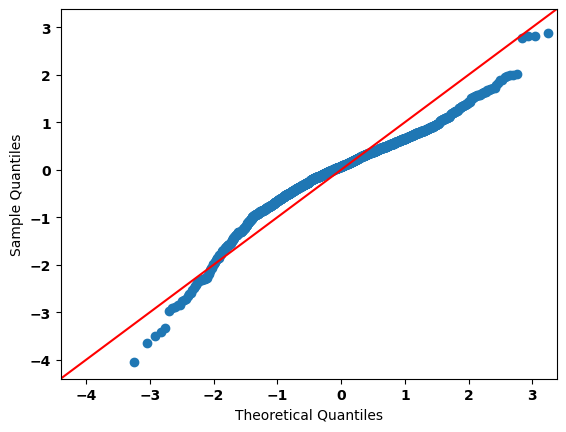

In [31]:
data_points = results_np.resid 

sm.qqplot(data_points, line ='45')
py.show()

<Axes: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance', ylabel='distance'>

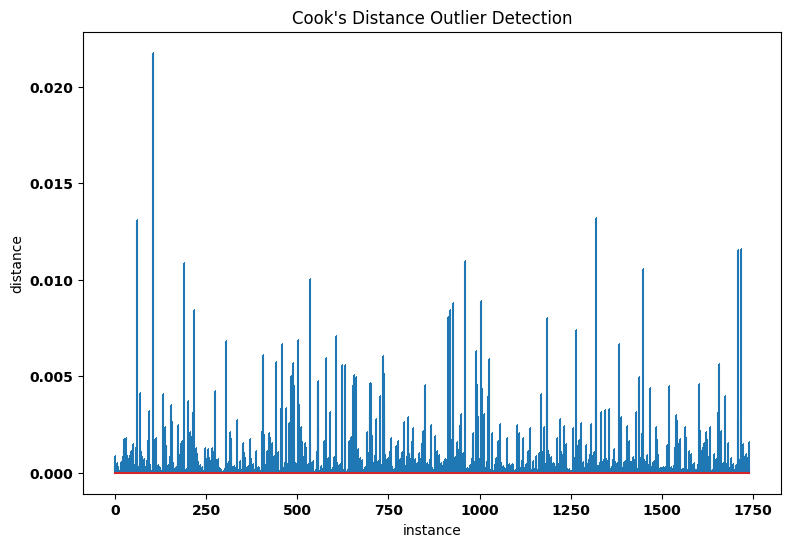

In [32]:
#create instance of influence
influence = results.get_influence()

#obtain Cook's distance for each observation
C, P = influence.cooks_distance

def plot_cooks_distance(c):
    _, ax = plt.subplots(figsize=(9,6))
    ax.stem(c, markerfmt=",")
    ax.set_xlabel("instance")
    ax.set_ylabel("distance")
    ax.set_title("Cook's Distance Outlier Detection")
    return ax

plot_cooks_distance(C)

In [33]:
y_pred = results.predict(X_test_log)
y_pred_result = np.exp(y_pred)

In [34]:
# for residuales, convert df to series
y_test_series = y_test.squeeze()

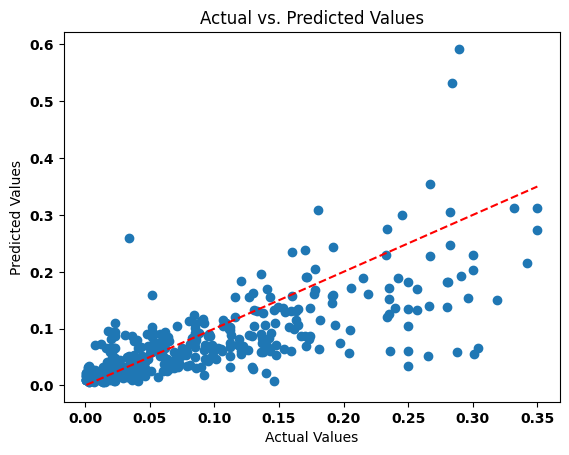

In [35]:
plt.scatter(y_test_series, y_pred_result)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([min(y_test_series), max(y_test_series)], [min(y_test_series), max(y_test_series)], color='red', linestyle='--')
plt.show()

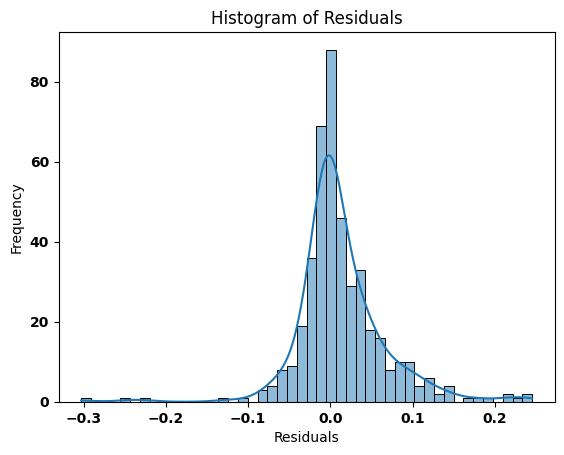

In [36]:
residuals = y_test_series - y_pred_result
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


In [89]:
compare_data["actual_salary_cap_as_perc"].describe()

count    435.000000
mean       0.082910
std        0.080968
min        0.001000
25%        0.021000
50%        0.052000
75%        0.127000
max        0.350000
Name: actual_salary_cap_as_perc, dtype: float64

In [56]:
compare_data = X_test.copy()
compare_data["actual_salary_cap_as_perc"] = y_test
compare_data["predicted_salary_cap_as_perc"] = y_pred_result
compare_data["difference"] = compare_data["predicted_salary_cap_as_perc"] - compare_data["actual_salary_cap_as_perc"]

In [100]:
len(compare_data[(compare_data.difference > 0.03486066974383097)].index)

84

In [99]:
len(compare_data[(compare_data.difference < -0.03486066974383097)].index)

149

In [101]:
MAE = np.mean(np.abs(compare_data["difference"]))
MSE = np.mean(compare_data["difference"]**2)
RMSE = np.sqrt(MSE)

In [102]:
print("Mean Absolute Error (MAE):", MAE)
print("Mean Squared Error (MSE):", MSE)
print("Root Mean Squared Error (RMSE):", RMSE)

Mean Absolute Error (MAE): 0.03486066974383097
Mean Squared Error (MSE): 0.0031261117040615643
Root Mean Squared Error (RMSE): 0.05591164193673411
